In [1]:
import numpy as np
import plate_map as pm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from unidec_modules import unidectools as ud
from copy import deepcopy 
from unidec_modules.v3_SeqChrom import *
import scipy
from copy import deepcopy
import copy

In [2]:
eng = SeqChrom()


UniDec Engine v.5.0.1

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_bin\UniDec.exe

UniDec Engine v.5.0.1

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_bin\UniDec.exe


In [3]:
spectra_path = "D:\\211111 mass spec\\processed\\211111 ctb ratio v2_336087_GA7_01_80179.d.mzML"
map_path = "C:\\Users\\cm19ljc\\Documents\\GitHub\\UniDec\\reaction maps\\CTB ratio map.xlsx"
eng.load_mzml(spectra_path)

Opening HDF5 File: D:\211111 mass spec\processed\211111 ctb ratio v2_336087_GA7_01_80179.d.hdf5
Reading mzML: D:\211111 mass spec\processed\211111 ctb ratio v2_336087_GA7_01_80179.d.mzML
[Warning] Not index found and build_index_from_scratch is False
Converted to gzip file to improve speed: D:\211111 mass spec\processed\211111 ctb ratio v2_336087_GA7_01_80179.d.mzML.gz
Error getting TIC in mzML; trying to make it...
Imported Data. Constructing TIC
Done


C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_modules\mzMLimporter.py:311: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.data = np.array(self.data)


True

In [4]:
eng.config.chrom_peak_width = 0.05 
eng.get_chrom_peaks(lb = 1, ub = 5.5) 

1311 2
Noise Level: 0.04683348211098782 Window: 0.05
Bad Peak [0.418533   0.91461132] 0.23773400000000006 [0.418533, 0.656267]
Bad Peak [0.726917   0.23707758] 0.35826700000000006 [0.418533, 0.7768]
1.14675 0.15792000000000006
2.08192 0.1579299999999999
3.01718 0.15375000000000005
3.95657 0.14961000000000046
4.88758 0.14961999999999964
5.95168 0.054039999999999644


(array([[1.14675   , 0.96622152],
        [2.08192   , 1.        ],
        [3.01718   , 0.96414786],
        [3.95657   , 0.96505542],
        [4.88758   , 0.96318439],
        [5.95168   , 0.26890564]]),
 array([[1.11765, 1.27557],
        [2.04867, 2.2066 ],
        [2.98393, 3.13768],
        [3.91917, 4.06878],
        [4.85433, 5.00395]]))

Getting scans: [126, 164]
Length merge axis: 38026
Getting scans: [350, 388]
Length merge axis: 38330
Getting scans: [575, 612]
Length merge axis: 38214
Getting scans: [800, 836]
Length merge axis: 38464
Getting scans: [1025, 1061]
Length merge axis: 38052


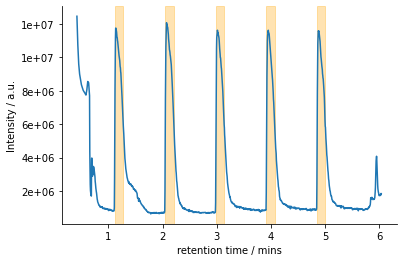

In [5]:
eng.add_chrom_peaks2() 
eng.plot_tic(peak_windows = True)

In [6]:
eng.update_config(masslb = 10000, massub = 100000, minmz = 750, peakthresh = 0.02)
eng.process_data()
eng.run_unidec()
eng.pick_peaks()
eng.integrate_all()

Execution Time: 0.13635610000000042
Execution Time: 19.8654091
Execution Time: 0.46981319999999727
Peak info saved to: D:\211111 mass spec\processed\UniDec_Figures_and_Files\211111 ctb ratio v2_336087_GA7_01_80179.d_extracts.txt


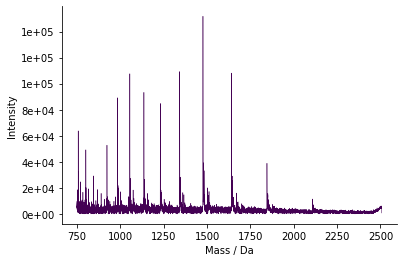

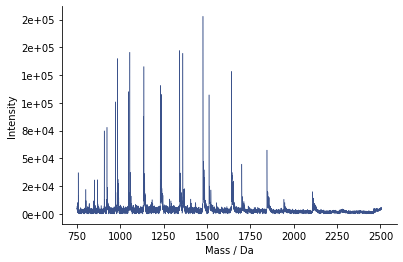

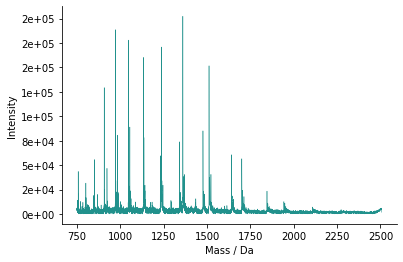

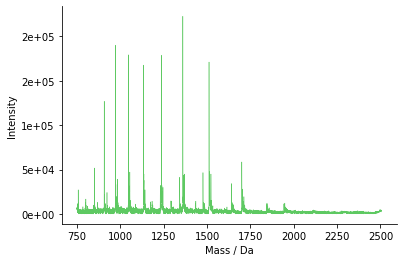

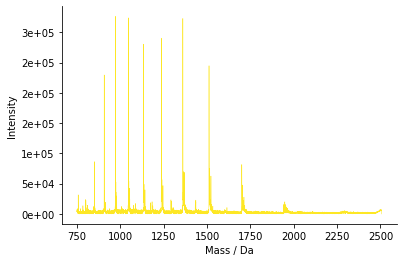

In [7]:
eng.plot_all(dtype = 'data2', combine = False, cmap = 'viridis')

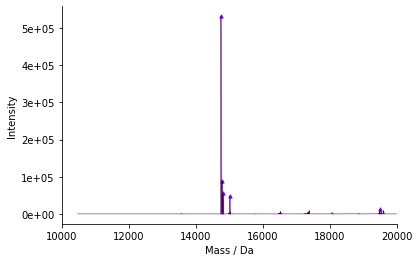

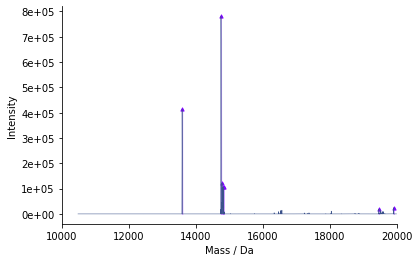

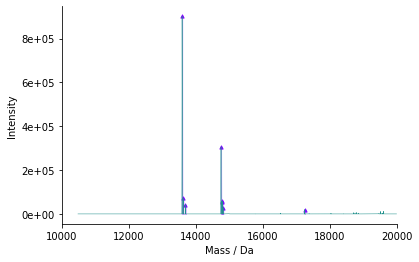

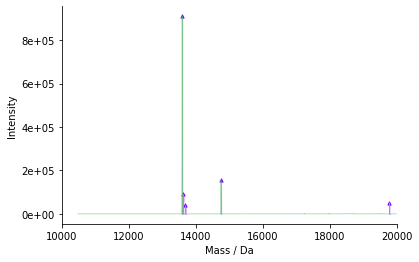

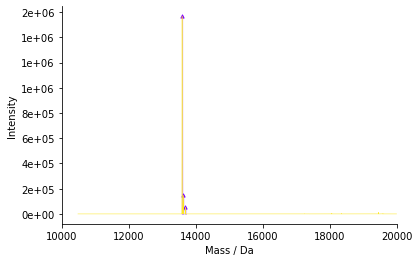

In [8]:
eng.plot_all(dtype = 'massdat', combine = False, cmap = 'viridis', xlim = [10000, 20000])

In [9]:
rmap = eng.upload_map(map_path)

In [10]:
species, wells = eng.upload_map(map_path)
species

,Reaction,Species,Concentration,Units,Mass,Reagent_Type,Sequence
0,ctb_mix,CTB-H6,NaN,uM,13597.42,Protein,NaN
1,ctb_mix,CTB-E9-H6,NaN,uM,14759.46,Protein,NaN


In [11]:
wells

,Type,Reaction,Time,Protein 1,Protein 2,Species,Valid
Well ID,,,,,,,
A1,Protein,ctb_mix,1,0.0,100.0,NaN,True
A2,Protein,ctb_mix,2,25.0,75.0,NaN,True
A3,Protein,ctb_mix,3,50.0,50.0,NaN,True
B1,Protein,ctb_mix,4,75.0,25.0,NaN,True
B2,Protein,ctb_mix,5,100.0,0.0,NaN,True
B3,NaN,NaN,NaN,NaN,NaN,NaN,True


In [12]:
self = eng
species, wells = eng.upload_map(map_path)
def process_maps(self, groupby = 'Reaction'):

    

    # Reaction OR Substrate Conc

    self.pmap2 = self.pmap[self.pmap['Type'] != 'empty']
    self.pmap2.loc[:, 'Species'] = np.nan

    for skey, sval in self.speciesmap.groupby(['Reaction']):
        splist = [Species(spval.to_dict('records')[0], name = spkey) for spkey, spval in sval.groupby('Species')]
        splist = colorcodeclass(splist)

        for s in splist:
            self.pmap2.loc[:, s.__name__] = np.nan
            self.pmap2.loc[self.pmap2['Reaction']==skey, s.__name__] = self.pmap2.apply(lambda _:deepcopy(s), axis = 1)

        spnames = [s.__name__ for s in splist]
        self.pmap2.loc[self.pmap2['Reaction']==skey, 'Species'] = self.pmap2.apply(lambda _:spnames, axis = 1)

    # update_vars

    if len(self.data.spectra) == len(self.pmap2):
        for i, s in enumerate(self.data.spectra):
            well_id = self.pmap2.index[i]
            timevar = self.pmap2['Time'].iloc[i]
            s.attrs['Variable 1'] = well_id
            s.var1 = well_id
            s.attrs['Variable 2'] = timevar
            s.var2 = timevar
            self.pmap2.loc[well_id, 'Spectra'] = s



    spectra = {s.var1:s for s in self.data.spectra}

    # update species with well info/metadata 

    groupby = 'Reaction' # Reaction OR Substrate Conc

    for index, row in self.pmap2.iterrows():
        for specs in row['Species']:
            row[specs] = deepcopy(row[specs])
            row[specs].coord = row.name
    #         print(row[specs])
            vals = row[~row.index.isin(row['Species'])].to_dict()
            row[specs].__dict__.update(vals)
    return self
            
# match peaks
# prep 

def peak_match(self, window = 10):
    window = 10

    intmat = np.array([])

    for index, row in self.pmap2.iterrows():

        rowints = np.array([])

        specieslist = list(row[row.index.isin(row['Species'])])
        theory_masses = np.array([sp.Mass for sp in specieslist])
        data_masses = np.array([p.mass for p in row['Spectra'].pks.peaks])
        pks = np.array([p for p in row['Spectra'].pks.peaks])

        # match algorithm 
        tm, dm = np.meshgrid(theory_masses, data_masses)
        diff = abs(tm - dm)
        diff[diff>window] = np.nan
        for i, d in enumerate(diff):
            if np.isnan(d).all()==False:
                minimum = np.nanargmin(d)
                data_peak = data_masses[i]

                specieslist[minimum].peak = pks[i]
                specieslist[minimum].integral = pks[i].integral[0]
                print("{}, {} = {}".format(row[row.index.isin(row['Species'])][minimum].__name__, data_peak, pks[i]))

                row[row.index.isin(row['Species'])][minimum].integral = pks[i].integral[0]
                row[row.index.isin(row['Species'])][minimum].peak = pks[i]
                np.append(rowints, pks[i].integral[0])
                print(row[row.index.isin(row['Species'])][minimum].integral)

    return self


In [13]:
self = process_maps(self)
self = peak_match(self)

TypeError: 'float' object is not iterable

In [ ]:
def normalise_peaks(self):
    for index, row in self.pmap2.iterrows():
        ints = []
        for s in row[row['Species']]:
            if type(s.integral) != list:
                ints.append(s.integral)

    #     ints = np.array([s.integral for s in row[row['Species']]])
        sum_ints = np.sum(ints)
        for s in row[row['Species']]:
            if type(s.integral) != list:
                s.percentage = s.integral/sum_ints
            else:
                s.percentage = 0
            print("{}:{}".format(s.__name__, s.percentage))
            
    return self

eng = normalise_peaks(eng)

In [ ]:
# get data

species = None
datatype = 'percentage'
rxndct = {}
groupby = 'Reaction'

# def extract_data(self):

rxns_tc = []
for k, v in self.pmap2.groupby(groupby):

    time = v['Time']
    speciesdct = {}
    speciestimedct = {}

    for index, row in v.iterrows():
        if species == None:
            species = row.Species

        if len(species) == 1:
            species = [species]

        for s in species:
            if s in speciesdct:
                speciesdct[s].append(getattr(row[s], datatype))
                speciestimedct[s].append(row['Time'])

            else:
                speciesdct[s] = [getattr(row[s], datatype)]
                speciestimedct[s] = [row['Time']]
    df = pd.DataFrame(speciesdct, index = time)
    rxns_tc.append(df)
    
if len(rxns_tc) == 1:
    rxns_tc = rxns_tc[0]
    
for name, y in speciesdct.items():

    plt.plot(time, y, label = name)
    plt.legend(loc = "center right")
    plt.title(eng.path)
    plt.show
        
    
rxndct[k] = pd.DataFrame(speciesdct, index = time)
speciesdct

In [ ]:
eng.chrompeaks_tranges

In [ ]:
df = pd.DataFrame(speciesdct, index = time)

In [ ]:
fig = plt.subplots()

for species in df.columns:

    tc = np.array(df[species])    
    if ~np.all((tc==0)):
        df[species].plot(label = species)
        plt.xlabel("Time / s")
        plt.ylabel("")
        plt.legend()

In [ ]:
self.datadct = rxndct
rxndct

In [ ]:
thresh = 0.8
ratedct = {}
for key, data in rxndct.items():
    x = np.array(data.index, dtype = float)
    x1i = int(len(x)*thresh -1)
    if x1i == 0:
        x1i = int(len(x)*thresh)
    if x1i == 0:
        x1i = 1
    x1 = float(x[x1i])
    
    y1 = data.iloc[x1i, :]
    y0 = data.iloc[0, :]
    x0 = float(x[0])
    
    m = (y0-y1)/(x0-x1)
    ratedct[key] = m
    c = y1-m*x1
    for species in data.columns:
        vy = m[species]*x +c[species]
        fig, ax = plt.subplots()
        ax.plot(x, data[species])
        ax.plot(x, vy, linestyle = 'dotted')
        
        ax.plot((x0, x1), (y1[species], y1[species]), color = 'purple', linestyle = 'dashed', linewidth = 0.5)
        ax.plot((x1, x1), (y0[species], y1[species]), color = 'purple', linestyle = 'dashed', linewidth = 0.5)

In [ ]:
ratedct